In [194]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [195]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import OneHotEncoder

In [196]:
# Load the malware dataset
data = pd.read_csv('Malware dataset.csv')
# Randomly select 100 rows from the dataset
data = data.sample(n=10000, random_state=42)
data.drop('hash', axis=1, inplace=True)

In [197]:
# Define the number of clients
num_clients = 3

# print(data)
# check for missing values
print(data.isnull().sum())



# fill missing values with mean of the column
data.fillna(data.mean(), inplace=True)

# get the number of unique values in each column
unique_counts = data.nunique()

# get the list of columns to drop
to_drop = [col for col in unique_counts.index if unique_counts[col] == len(data)]

# drop the columns
data.drop(to_drop, axis=1, inplace=True)

# Split the dataset into features and labels
X = data.drop('classification', axis=1)
y = data['classification']
# print(y)

# converting data to comparable data
# one_hot_encoder = OneHotEncoder()
# one_hot_encoded = one_hot_encoder.fit_transform(X.iloc[:, 0].values.reshape(-1, 1)).toarray()
# print(one_hot_encoded.shape)
# X = pd.concat([X.drop('hash', axis=1), pd.DataFrame(one_hot_encoded)], axis=1)
# X.columns = X.columns.astype(str)
# X = X.values


millisecond          0
classification       0
state                0
usage_counter        0
prio                 0
static_prio          0
normal_prio          0
policy               0
vm_pgoff             0
vm_truncate_count    0
task_size            0
cached_hole_size     0
free_area_cache      0
mm_users             0
map_count            0
hiwater_rss          0
total_vm             0
shared_vm            0
exec_vm              0
reserved_vm          0
nr_ptes              0
end_data             0
last_interval        0
nvcsw                0
nivcsw               0
min_flt              0
maj_flt              0
fs_excl_counter      0
lock                 0
utime                0
stime                0
gtime                0
cgtime               0
signal_nvcsw         0
dtype: int64


<ipython-input-197-a58809f0d694>:11: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


In [198]:
# Partition the dataset among the clients
X_partitions = []
y_partitions = []

for i in range(num_clients):
    # Split the dataset randomly
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    
    # Append the training set to the partitions
    X_partitions.append(X_train)
    y_partitions.append(y_train)
    
# Convert the partitions to numpy arrays
X_partitions = [pd.DataFrame(X) for X in X_partitions]
y_partitions = [pd.DataFrame(y) for y in y_partitions]


In [199]:
from sklearn.metrics import pairwise_distances
# from sklearn.metrics import f1_score, accuracy_score

# Initialize the global model
global_model = None

# Define the number of clusters (i.e., the number of local models)
num_clusters = len(X_partitions)

# Train local models
local_models = []
for i in range(num_clusters):
    # Train the local model on the current partition
    kmedoids = KMedoids(n_clusters=1, random_state=i)
    kmedoids.fit(X_partitions[i])
    local_model = kmedoids

    # Add the local model to the list of local models
    local_models.append(local_model)

# Perform federated learning
for epoch in range(num_epochs):
    # Aggregate the local models
    cluster_centers = [model.cluster_centers_ for model in local_models]
    global_model = np.mean(cluster_centers, axis=0)

    # Train the local models on the global model
    for i in range(num_clusters):
        # Compute the distance between the global model and the local data
        # Reshape input data to a 2D array with one column
        X_2d = X_partitions[i].values.reshape(-1, 33)

        # Compute distances to cluster centers
        distances = pairwise_distances(X_2d, global_model.reshape(1, -1))

        # Assign each data point to the nearest cluster
        assignments = np.argmin(distances, axis=1)

        # Train the local model on the assigned data points
        for j in range(local_models[i].n_clusters):
            # Select the data points assigned to the current cluster
            cluster_data = X_partitions[i][assignments == j]

            # Train the local model on the selected data points
            local_model = KMedoids(n_clusters=1, random_state=i)
            local_model.fit(cluster_data)
            local_models[i] = local_model

# Use the global model for prediction
y_pred = np.argmin(pairwise_distances(X_test, global_model.reshape(1, -1)), axis=1)




/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
Accuracy: 0.503


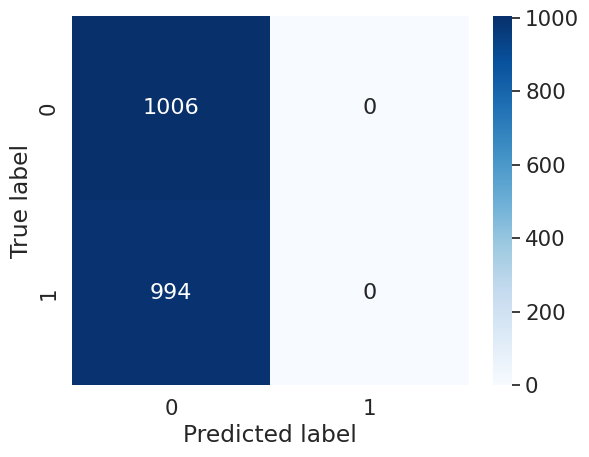

In [200]:
label_map = {'benign': 0, 'malware': 1}
y_test_all = np.array([label_map[label] for label in y_test])

from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test_all, y_pred)

# Compute precision
precision = precision_score(y_test_all, y_pred)

# Compute recall
recall = recall_score(y_test_all, y_pred)

# Compute accuracy
accuracy = accuracy_score(y_test_all, y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
# Plot the confusion matrix with values inside it
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder

# Define the local models
local_models = []
for i in range(num_clusters):
    # Train the local model on the current partition using DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(X_partitions[i])
    local_model = dbscan

    # Add the local model to the list of local models
    local_models.append(local_model)

# Define the global model
class MyModel(nn.Module):
    def __init__(self, num_features):
        super(MyModel, self).__init__()
        self.dense1 = nn.Linear(num_features, 64)
        self.dense2 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

global_model = MyModel(num_features=X.shape[1])

# Define the optimizer and loss function
optimizer = optim.SGD(global_model.parameters(), lr=0.1)
loss_fn = F.cross_entropy

# Train the global model using federated learning
num_epochs = 10
for epoch in range(num_epochs):
    # Update the global model using local models
    for i in range(len(X_partitions)):
        # Get the data from the current partition
        x = torch.from_numpy(X_partitions[i].values).float()

        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y_partitions[i])
        y = torch.from_numpy(y).long()

        # Compute the local gradients and update the global model
        local_model = local_models[i]
        preds = local_model.fit_predict(x)
        mask = preds != -1
        optimizer.zero_grad()
        loss = loss_fn(global_model(x[mask]), y[mask])
        loss.backward()
        optimizer.step()

    # Evaluate the global model
    with torch.no_grad():
      x = torch.from_numpy(X.to_numpy()).float()
      y = torch.from_numpy(y.numpy()).long()
      num_samples = min(x.shape[0], y.shape[0], 8000)
      indices = torch.randperm(num_samples)
      x = x[indices]
      y = y[indices]

      # Compute the loss and accuracy
      loss = loss_fn(global_model(x), y)
      preds = torch.argmax(global_model(x), dim=1)
      accuracy = torch.mean((preds == y).float())
      precision = torch.sum((preds == y).float() * (y == 1).float()) / torch.sum((preds == 1).float())

      # Print the epoch, loss, accuracy, and precision
      print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}, Precision: {precision.item():.4f}')



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1, Loss: 1.0986, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 2, Loss: 1.0540, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 3, Loss: 1.0174, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 4, Loss: 0.9871, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 5, Loss: 0.9617, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 6, Loss: 0.9402, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 7, Loss: 0.9218, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 8, Loss: 0.9060, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 9, Loss: 0.8921, Accuracy: 0.4969, Precision: 0.4969


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 10, Loss: 0.8800, Accuracy: 0.4969, Precision: 0.4969
